In [7]:
import os
import librosa
import wave
import matplotlib.pyplot as plt
import soundfile as sf

In [8]:
def extract_audio_features(audio_path):
    y, sr = librosa.load(audio_path, res_type=None, sr=None, mono=False)
    duration = librosa.get_duration(y=y, sr=sr)
    channels = 'Mono' if y.ndim == 1 else 'Stereo'
    return {'Audio': audio_path, 'Durata (s)': duration, 'Canali': channels, 'Frequenza di campionamento (Hz)': sr}



In [9]:
# Calcola la mediana
def calculate_median(durations):
    # Ordina la lista
    sorted_durations = sorted(durations)
    n = len(sorted_durations)
    
    # Se il numero di elementi è dispari, ritorna l'elemento centrale
    if n % 2 == 1:
        median = sorted_durations[n // 2]
    else:
        # Se il numero di elementi è pari, ritorna la media dei due elementi centrali
        median = (sorted_durations[n // 2 - 1] + sorted_durations[n // 2]) / 2
    
    return median

# Esempio di lista di durate in secondi
durat = [300, 150, 600, 200, 500]

median_d = calculate_median(durat)
print(f"La mediana delle durate è: {median_d} secondi")

La mediana delle durate è: 300 secondi


In [10]:
# Nel caso in cui volessimo dividere la ricerca tra target e non target, basta fare due for separati e passare 
# trargetpath e non target path al posto di dataset
target_path = 'Dataset/Target'
non_target_path = 'Dataset/Non-Target'

# Lista per memorizzare i percorsi dei file audio
audio_files = []

# Scorrere ricorsivamente le cartelle nel dataset
for root, dirs, files in os.walk('Dataset'):
    for file in files:
        if file.endswith(('.wav','.mp3')):
           audio_files.append(os.path.join(root, file))
audio_features = []
for file in audio_files:
    feature1 = extract_audio_features(file)
    audio_features.append(feature1)
print(audio_features)



[{'Audio': 'Dataset\\Non-Target\\Ambient Noise\\0f9867d8-fcf7-40d1-b846-3f7fb8100eb7.mp3', 'Durata (s)': 31.207619047619048, 'Canali': 'Mono', 'Frequenza di campionamento (Hz)': 44100}, {'Audio': 'Dataset\\Non-Target\\Ambient Noise\\2b68b3a9-7c0d-4452-bbe5-cc99b5d4fb61.mp3', 'Durata (s)': 31.207619047619048, 'Canali': 'Mono', 'Frequenza di campionamento (Hz)': 44100}, {'Audio': 'Dataset\\Non-Target\\Ambient Noise\\2f574049-3325-446c-a8ac-2e5b31e9e32f.mp3', 'Durata (s)': 31.207619047619048, 'Canali': 'Mono', 'Frequenza di campionamento (Hz)': 44100}, {'Audio': 'Dataset\\Non-Target\\Ambient Noise\\30679527-fd7a-4cad-8c7d-cb1bcc07604d.mp3', 'Durata (s)': 31.207619047619048, 'Canali': 'Mono', 'Frequenza di campionamento (Hz)': 44100}, {'Audio': 'Dataset\\Non-Target\\Ambient Noise\\f9652ad2-39f5-41b4-a8e4-89171a864f03.mp3', 'Durata (s)': 31.207619047619048, 'Canali': 'Mono', 'Frequenza di campionamento (Hz)': 44100}, {'Audio': 'Dataset\\Non-Target\\Antarctic Minke Whale\\Bioduck.wav', 'Dura

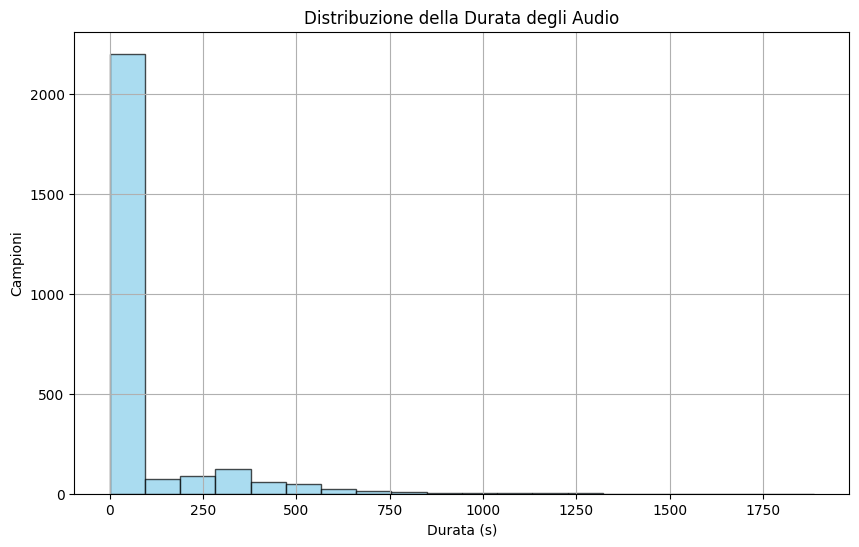

In [11]:
import matplotlib.pyplot as plt

durations = [feat['Durata (s)'] for feat in audio_features]

# Grafico della distribuzione della durata
plt.figure(figsize=(10, 6))
plt.hist(durations, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribuzione della Durata degli Audio')
plt.xlabel('Durata (s)')
plt.ylabel('Campioni')
plt.grid(True)
plt.show()

In [12]:
durations = [feat['Durata (s)'] for feat in audio_features]

median_duration = calculate_median(durations)
print(f"La mediana delle durate degli audio è: {median_duration}")

La mediana delle durate degli audio è: 3.440625


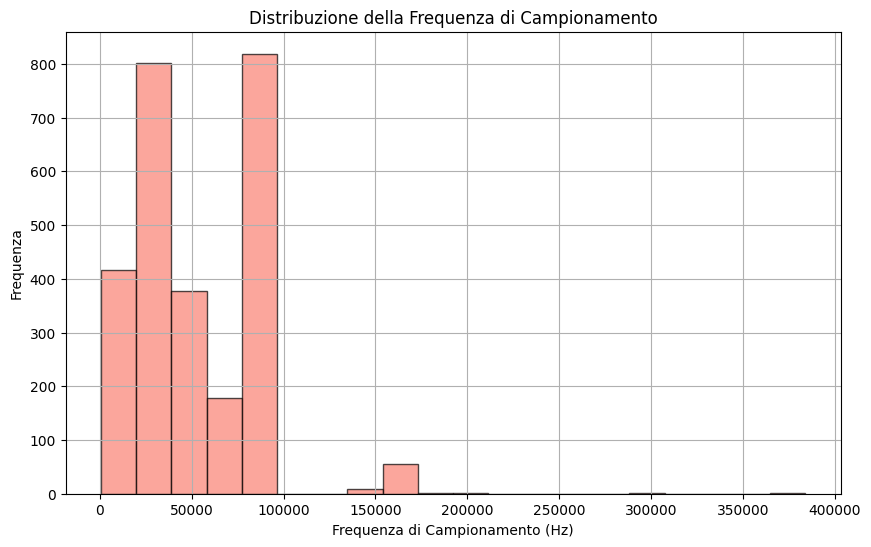

In [13]:
import matplotlib.pyplot as plt

frequencies = [feat['Frequenza di campionamento (Hz)'] for feat in audio_features]

# Grafico della distribuzione della frequenza di campionamento
plt.figure(figsize=(10, 6))
plt.hist(frequencies, bins=20, color='salmon', edgecolor='black', alpha=0.7)
plt.title('Distribuzione della Frequenza di Campionamento')
plt.xlabel('Frequenza di Campionamento (Hz)')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

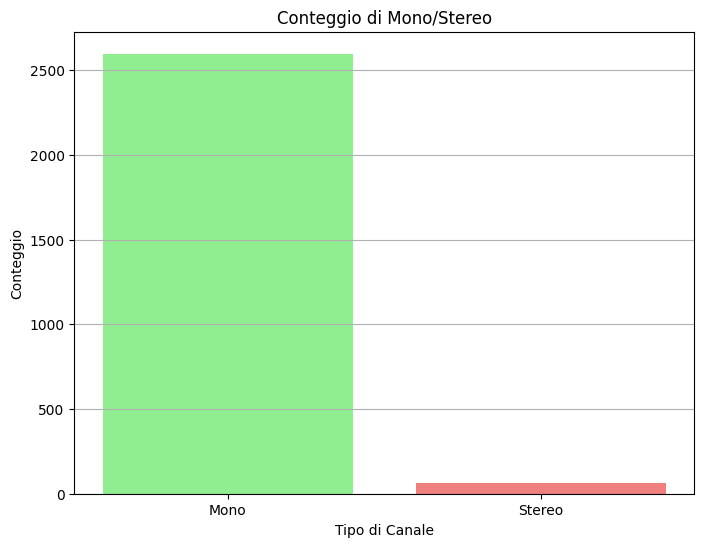

In [14]:
import matplotlib.pyplot as plt

channels = [feat['Canali'] for feat in audio_features]

# Grafico del conteggio di mono/stereo
plt.figure(figsize=(8, 6))
plt.bar(['Mono', 'Stereo'], [channels.count('Mono'), channels.count('Stereo')], color=['lightgreen', 'lightcoral'])
plt.title('Conteggio di Mono/Stereo')
plt.xlabel('Tipo di Canale')
plt.ylabel('Conteggio')
plt.grid(axis='y')
plt.show()

Apertura del file: Dataset\Non-Target\Antarctic Minke Whale\Bioduck.wav
Apertura del file: Dataset\Non-Target\Arnoux’s Beaked Whale\Arnoux-beaked-whales-rogers-1.wav
Apertura del file: Dataset\Non-Target\Arnoux’s Beaked Whale\Arnoux-beaked-whales-rogers-2.wav
Apertura del file: Dataset\Non-Target\Arnoux’s Beaked Whale\Arnoux-beaked-whales-rogers-3.wav
Apertura del file: Dataset\Non-Target\Arnoux’s Beaked Whale\Arnoux-beaked-whales-rogers-4.wav
Apertura del file: Dataset\Non-Target\Arnoux’s Beaked Whale\Arnoux-beaked-whales-rogers-5.wav
Apertura del file: Dataset\Non-Target\Arnoux’s Beaked Whale\Arnoux-beaked-whales-rogers-6.wav
Apertura del file: Dataset\Non-Target\Atlantic cod\SanctSound_SB01_01_atlanticcod_20181113T024154Z.wav
Apertura del file: Dataset\Non-Target\Atlantic croaker\Croaker.wav
Apertura del file: Dataset\Non-Target\Atlantic Spotted Dolphin\61025001.wav
Apertura del file: Dataset\Non-Target\Atlantic Spotted Dolphin\61025002.wav
Apertura del file: Dataset\Non-Target\Atla

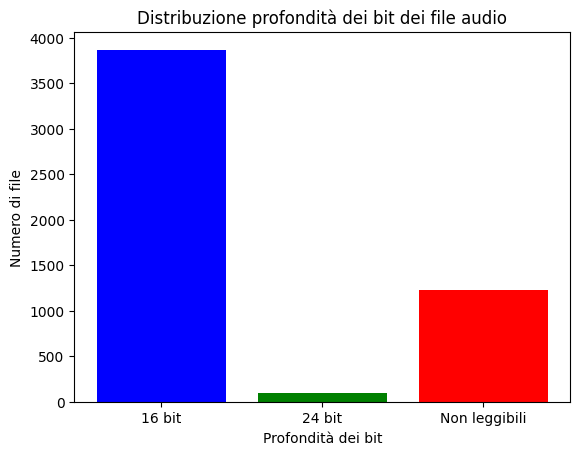

In [15]:
import wave
#commit
for root, dirs, files in os.walk('Dataset'):
    for file in files:
        if file.endswith(('.wav')):
           audio_files.append(os.path.join(root, file))

count_16bit=0
count_24bit=0
count_unreadable=0
for file in audio_files:
    if file.endswith('.wav'):
        print("Apertura del file:", file)  # Stampare il percorso del file
        try:
            with wave.open(file, 'rb') as audio_file:
                # Ottieni la profondità dei bit
                depth_bit = audio_file.getsampwidth() * 8
                if depth_bit ==16 : count_16bit+=1
                else: count_24bit+=1
        except Exception as e:
            print("Errore durante l'apertura del file:", e)
            count_unreadable+=1
            continue  # Passa al prossimo file
        
        
# Etichette delle colonne
labels = ['16 bit', '24 bit', 'Non leggibili']

# Dati da visualizzare nel grafico
data = [count_16bit, count_24bit, count_unreadable]

# Creazione del grafico a barre
plt.bar(labels, data, color=['blue', 'green', 'red'])

# Aggiunta di titolo e etichette
plt.title('Distribuzione profondità dei bit dei file audio')
plt.xlabel('Profondità dei bit')
plt.ylabel('Numero di file')

# Mostra il grafico
plt.show()